In [150]:
import numpy as np
from sklearn.model_selection import train_test_split
# Cargar el archivo
data = np.load("df-deepfake-lbp.npz")

# Acceder a los arrays
X = data['X']
y = data['y']
uuids = data['uuids']


Forma1

In [153]:
from sklearn.model_selection import GroupShuffleSplit

# 1. Dividir train (70%) y temporal (30%)
splitter_temp = GroupShuffleSplit(test_size=0.4, n_splits=1, random_state=42)
train_idx, temp_idx = next(splitter_temp.split(X, groups=uuids))

# 2. Dividir temporal en val (15%) y test (15%)
splitter_final = GroupShuffleSplit(test_size=0.5, n_splits=1, random_state=42)
val_idx, test_idx = next(splitter_final.split(X[temp_idx], groups=uuids[temp_idx]))
val_idx = temp_idx[val_idx]  # Ajustar índices al array original
test_idx = temp_idx[test_idx]

# 3. Crear conjuntos FINALES (X e y se filtran con los mismos índices)
X_train, y_train = X[train_idx], y[train_idx]  # <-- X y y de train
X_val, y_val = X[val_idx], y[val_idx]          # <-- X y y de val
X_test, y_test = X[test_idx], y[test_idx]      # <-- X y y de test


# Guardar todos los conjuntos en un único archivo
np.savez_compressed(
    "deepfake_dataset_splits.npz",  
    X_train=X_train, y_train=y_train,  # Train
    X_val=X_val, y_val=y_val,          # Validation
    X_test=X_test, y_test=y_test,      # Test
    uuids_train=uuids[train_idx],      # UUIDs de train (opcional)
    uuids_val=uuids[val_idx],          # UUIDs de val (opcional)
    uuids_test=uuids[test_idx]         # UUIDs de test (opcional)
)

Forma 2

In [146]:
# Agrupar por paciente
df = pd.DataFrame({'uuid': uuids, 'label': y})

# Asegúrate que cada paciente tiene una sola clase (revisar antes)
df_group = df.groupby('uuid').agg({'label': 'first'}).reset_index()

# Split estratificado por paciente
train_uuids, temp_uuids = train_test_split(
    df_group['uuid'], 
    test_size=0.4, 
    stratify=df_group['label'], 
    random_state=42
)

val_uuids, test_uuids = train_test_split(
    temp_uuids, 
    test_size=0.5, 
    stratify=df_group.set_index('uuid').loc[temp_uuids]['label'], 
    random_state=42
)

# Crear índices finales
train_idx = df[df['uuid'].isin(train_uuids)].index
val_idx = df[df['uuid'].isin(val_uuids)].index
test_idx = df[df['uuid'].isin(test_uuids)].index

# 3. Crear conjuntos FINALES (X e y se filtran con los mismos índices)
X_train, y_train = X[train_idx], y[train_idx]  # <-- X y y de train
X_val, y_val = X[val_idx], y[val_idx]          # <-- X y y de val
X_test, y_test = X[test_idx], y[test_idx]      # <-- X y y de test

# Guardar todos los conjuntos en un único archivo
np.savez_compressed(
    "deepfake_dataset_splits.npz",  
    X_train=X_train, y_train=y_train,  # Train
    X_val=X_val, y_val=y_val,          # Validation
    X_test=X_test, y_test=y_test,      # Test
    uuids_train=uuids[train_idx],      # UUIDs de train (opcional)
    uuids_val=uuids[val_idx],          # UUIDs de val (opcional)
    uuids_test=uuids[test_idx]         # UUIDs de test (opcional)
)


In [154]:
# Conteo de clases
unique, counts = np.unique(y_train, return_counts=True)
print("Conteo de clases en y_train:")
for cls, cnt in zip(unique, counts):
    print(f"Clase {cls}: {cnt} muestras")

# Conteo de clases
unique, counts = np.unique(y_val, return_counts=True)
print("Conteo de clases en y_val:")
for cls, cnt in zip(unique, counts):
    print(f"Clase {cls}: {cnt} muestras")

# Conteo de clases
unique, counts = np.unique(y_test, return_counts=True)
print("Conteo de clases en y_test:")
for cls, cnt in zip(unique, counts):
    print(f"Clase {cls}: {cnt} muestras")

Conteo de clases en y_train:
Clase 0: 930 muestras
Clase 1: 1050 muestras
Conteo de clases en y_val:
Clase 0: 90 muestras
Clase 1: 360 muestras
Conteo de clases en y_test:
Clase 0: 375 muestras
Clase 1: 285 muestras


Logistic Regression

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Cargar datos
data = np.load("deepfake_dataset_splits.npz")
X_train = data['X_train']
y_train = data['y_train']


# Escalar manualmente
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)



# Modelo base
lr = LogisticRegression(max_iter=1000)

# Definir grilla de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],             # Regularización
    'solver': ['lbfgs', 'liblinear'],         # Algoritmos
    'penalty': ['l2']                         # Tipo de penalización (solo 'l2' es compatible con lbfgs y liblinear)
}

# Métricas para evaluar
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

# Grid Search con CV
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5,
                    scoring=scoring, refit='f1', return_train_score=False)

# Entrenar
grid.fit(X_scaled, y_train)

# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.best_score_:.4f}")

# Puedes imprimir más métricas si deseas:
means = grid.cv_results_
print(f"✅ Accuracy medio: {means['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:   {means['mean_test_recall'][grid.best_index_]:.4f}")


🔍 Mejor combinación de hiperparámetros: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
📈 Mejor F1-score (CV): 0.6968
✅ Accuracy medio: 0.6707
✅ Recall medio:   0.7221


In [125]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

# 1. Cargar datos
data = np.load("deepfake_dataset_splits.npz")
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']

# 2. Escalado y selección de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Selección de las 20 mejores características (ajusta este número según necesidad)
selector = SelectKBest(f_classif, k=20)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)

# 3. Balanceo mediante class_weight
classes = np.unique(y_train)
class_weights = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y_train)))

# 4. Modelo con ajuste fino
lr = LogisticRegression(
    C=0.1,                   # Mayor regularización
    penalty='l2',
    solver='liblinear',
    class_weight=class_weights,  # Balance automático
    max_iter=1000,           # Más iteraciones para convergencia
    random_state=42
)

# 5. Entrenamiento y evaluación
lr.fit(X_train_selected, y_train)

print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, lr.predict(X_train_selected), target_names=["Real", "Fake"]))

print("\n🔹 Evaluación en VALIDACIÓN:")
y_pred_val = lr.predict(X_val_selected)
print(classification_report(y_val, y_pred_val, target_names=["Real", "Fake"]))

# 6. Análisis adicional (opcional)
print("\nFeatures seleccionadas:", X_train_selected.shape[1])
print("Coeficientes más importantes:")
print(sorted(zip(selector.scores_, range(X_train_scaled.shape[1])), reverse=True)[:10])

🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

        Real       0.64      0.66      0.65      1050
        Fake       0.69      0.67      0.68      1155

    accuracy                           0.67      2205
   macro avg       0.66      0.67      0.66      2205
weighted avg       0.67      0.67      0.67      2205


🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

        Real       0.44      0.41      0.42       195
        Fake       0.48      0.52      0.50       210

    accuracy                           0.46       405
   macro avg       0.46      0.46      0.46       405
weighted avg       0.46      0.46      0.46       405


Features seleccionadas: 20
Coeficientes más importantes:
[(139.05435974602517, 21), (130.49433608672894, 22), (102.08122624373964, 0), (92.32378340736473, 8), (89.58763183719284, 1), (65.41937912033795, 24), (57.68408421198129, 25), (54.803321835091715, 19), (49.16077774487696, 20), (46.99676

Knn Neighbors

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Cargar datos
data = np.load("deepfake_dataset_splits.npz")
X_train = data['X_train']
y_train = data['y_train']

# Calcular pesos para TRAIN (usando y_train)
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Modelo base
knn = KNeighborsClassifier()

# Grilla de hiperparámetros
param_grid = {
    'n_neighbors': [ 15, 25, 35],
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan']
}

# Scoring múltiple
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

# GridSearch con múltiples métricas
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',  # el mejor se elige por f1
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenar
grid.fit(X_scaled, y_train)

# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.cv_results_['mean_test_f1'][grid.best_index_]:.4f}")
print(f"✅ Accuracy medio:       {grid.cv_results_['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:         {grid.cv_results_['mean_test_recall'][grid.best_index_]:.4f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
🔍 Mejor combinación de hiperparámetros: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}
📈 Mejor F1-score (CV): 0.9509
✅ Accuracy medio:       0.9451
✅ Recall medio:         0.9354


In [113]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import classification_report
import numpy as np

# 1. Cargar datos
data = np.load("deepfake_dataset_splits.npz")
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']

# 2. Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 3. Selección de features (VarianceThreshold + Top 20)
# Primero elimina features con varianza < 0.01
var_selector = VarianceThreshold(threshold=0.01)
X_train_var = var_selector.fit_transform(X_train_scaled)
X_val_var = var_selector.transform(X_val_scaled)

# Luego selecciona las 20 mejores con ANOVA F
kbest_selector = SelectKBest(f_classif, k=20)
X_train_selected = kbest_selector.fit_transform(X_train_var, y_train)
X_val_selected = kbest_selector.transform(X_val_var)

# 4. Entrenar KNN (configuración original)
knn = KNeighborsClassifier(
    n_neighbors=50,
    weights='uniform',
    metric='euclidean'
)
knn.fit(X_train_selected, y_train)

# 5. Evaluación
print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, knn.predict(X_train_selected)))

print("\n🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, knn.predict(X_val_selected)))

# Opcional: Ver features seleccionadas
print(f"\nSe seleccionaron {X_train_selected.shape[1]} features.")
print("Scores de las features seleccionadas:", kbest_selector.scores_[kbest_selector.get_support()])

🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       735
           1       0.88      0.89      0.88       960

    accuracy                           0.87      1695
   macro avg       0.87      0.86      0.87      1695
weighted avg       0.87      0.87      0.87      1695


🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       0.46      0.42      0.44       240
           1       0.65      0.69      0.67       375

    accuracy                           0.58       615
   macro avg       0.56      0.55      0.55       615
weighted avg       0.58      0.58      0.58       615


Se seleccionaron 20 features.
Scores de las features seleccionadas: [ 44.16249644  35.76016465  17.39003902  11.5636855   27.52878297
 124.22427897 129.80271157 109.49668531  52.57263597   8.25835321
   8.15699182   6.08071788  17.85419208  96.01877444 101.8861173
 104.80799766  51.89177891  

Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Cargar datos
data = np.load("deepfake_dataset_splits.npz")
X_train = data['X_train']
y_train = data['y_train']


# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Definir modelo base
rf = RandomForestClassifier(random_state=42)

# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

# Crear GridSearchCV
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,  # también puedes usar 'recall' si priorizas eso
    cv=5,
    refit='f1',  # el mejor se elige por f1
    n_jobs=-1,
    verbose=1
)

# Ejecutar búsqueda
grid.fit(X_scaled, y_train)

# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.cv_results_['mean_test_f1'][grid.best_index_]:.4f}")
print(f"✅ Accuracy medio:       {grid.cv_results_['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:         {grid.cv_results_['mean_test_recall'][grid.best_index_]:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Mejor combinación de hiperparámetros: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
📈 Mejor F1-score (CV): 0.9622
✅ Accuracy medio:       0.9601
✅ Recall medio:         0.9662


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np

# Cargar datos
data = np.load("deepfake_dataset_splits.npz")
X_train = data['X_train']
y_train = data['y_train']

X_val = data['X_val']
y_val = data['y_val']


# 2. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 3. Crear y entrenar modelo
rf = RandomForestClassifier(max_depth= 5, min_samples_leaf= 1, min_samples_split= 2, n_estimators = 100, random_state=42)
rf.fit(X_train_scaled, y_train)

# 4. Evaluar en entrenamiento y validación
print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, rf.predict(X_train_scaled)))

print("🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, rf.predict(X_val_scaled)))


🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       960
           1       0.90      0.95      0.93       960

    accuracy                           0.93      1920
   macro avg       0.93      0.93      0.93      1920
weighted avg       0.93      0.93      0.93      1920

🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       0.46      0.48      0.47       240
           1       0.66      0.64      0.65       375

    accuracy                           0.58       615
   macro avg       0.56      0.56      0.56       615
weighted avg       0.58      0.58      0.58       615



SVM

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np

# Cargar datos
data_train = np.load("deepfake_trainval.npz")
X = data_train['X']
y = data_train['y']

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir modelo
svm = SVC(random_state=42)

# Grilla de hiperparámetros
param_grid = {
        'kernel': ['linear','rbf', 'poly' ],
        'C': [0.1, 1, 10],
        'degree': [2, 3],
        'gamma': ['scale', 0.01, 0.1]
    }

# Métricas
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

# GridSearchCV
grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Ajustar
grid.fit(X_scaled, y)

# Resultados
print("🔍 Mejor combinación de hiperparámetros:", grid.best_params_)
print(f"📈 Mejor F1-score (CV): {grid.cv_results_['mean_test_f1'][grid.best_index_]:.4f}")
print(f"✅ Accuracy medio:       {grid.cv_results_['mean_test_accuracy'][grid.best_index_]:.4f}")
print(f"✅ Recall medio:         {grid.cv_results_['mean_test_recall'][grid.best_index_]:.4f}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
🔍 Mejor combinación de hiperparámetros: {'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
📈 Mejor F1-score (CV): 0.9803
✅ Accuracy medio:       0.9785
✅ Recall medio:         0.9746


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np

# Cargar datos
data_trainval = np.load("deepfake_trainval.npz")
X = data_trainval['X']
y = data_trainval['y']

# 1. Dividir en entrenamiento y validación (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 3. Crear y entrenar modelo
svm = SVC(C = 10, degree = 2, gamma = 0.1, kernel = 'rbf', random_state=42)
svm.fit(X_train_scaled, y_train)

# 4. Evaluar en entrenamiento y validación
print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, svm.predict(X_train_scaled)))

print("🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, svm.predict(X_val_scaled)))


🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       571
           1       0.99      0.99      0.99       693

    accuracy                           0.99      1264
   macro avg       0.99      0.99      0.99      1264
weighted avg       0.99      0.99      0.99      1264

🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       143
           1       0.98      0.99      0.99       174

    accuracy                           0.99       317
   macro avg       0.99      0.99      0.99       317
weighted avg       0.99      0.99      0.99       317



Neural Network

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Cargar datos
data_trainval = np.load("deepfake_trainval.npz")
X = data_trainval['X']
y = data_trainval['y']

# 1. Dividir en entrenamiento y validación (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 3. Definir la red neuronal
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # Usaremos BCEWithLogitsLoss

# 4. Preparar tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

# 5. Inicializar modelo, pérdida y optimizador
model = SimpleNN(input_size=X_train.shape[1], hidden_size=32)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. Entrenamiento
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# 7. Evaluación en entrenamiento
model.eval()
with torch.no_grad():
    outputs_train = model(X_train_tensor)
    probs_train = torch.sigmoid(outputs_train).numpy()
    y_pred_train = (probs_train > 0.5).astype(int).flatten()

print("🔹 Evaluación en TRAIN:")
print(classification_report(y_train, y_pred_train))

# 8. Evaluación en validación
with torch.no_grad():
    outputs_val = model(X_val_tensor)
    probs_val = torch.sigmoid(outputs_val).numpy()
    y_pred_val = (probs_val > 0.5).astype(int).flatten()

print("🔹 Evaluación en VALIDACIÓN:")
print(classification_report(y_val, y_pred_val))


🔹 Evaluación en TRAIN:
              precision    recall  f1-score   support

           0       0.71      0.58      0.64       571
           1       0.70      0.81      0.75       693

    accuracy                           0.70      1264
   macro avg       0.70      0.69      0.69      1264
weighted avg       0.70      0.70      0.70      1264

🔹 Evaluación en VALIDACIÓN:
              precision    recall  f1-score   support

           0       0.65      0.62      0.64       143
           1       0.70      0.72      0.71       174

    accuracy                           0.68       317
   macro avg       0.67      0.67      0.67       317
weighted avg       0.68      0.68      0.68       317



             0         1         2         3         4         5         6   \
label                                                                         
0      0.040483  0.024919  0.013965  0.010321  0.007772  0.006414  0.005606   
1      0.043586  0.026253  0.014277  0.010514  0.008016  0.006429  0.005643   

             7         8         9   ...        16        17        18  \
label                                ...                                 
0      0.006321  0.007432  0.009412  ...  0.008068  0.007188  0.006193   
1      0.006119  0.007086  0.009069  ...  0.008076  0.007405  0.006430   

             19        20        21        22        23        24        25  
label                                                                        
0      0.006667  0.007480  0.010137  0.015548  0.020548  0.284162  0.349465  
1      0.007130  0.007864  0.010783  0.016176  0.020717  0.268121  0.358998  

[2 rows x 26 columns]


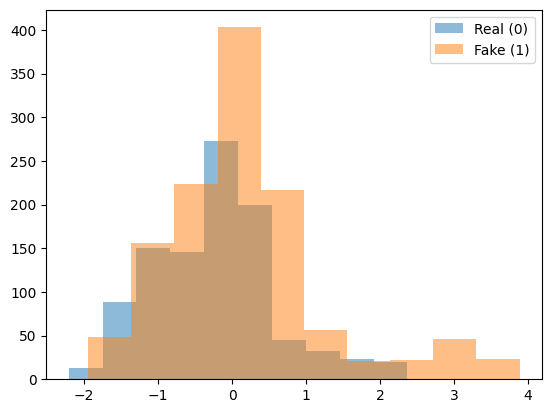

In [54]:
# Calcular estadísticas básicas por clase
import pandas as pd
df_train = pd.DataFrame(X_train)
df_train['label'] = y_train
print(df_train.groupby('label').mean())  # ¿Hay features con medias muy distintas?

# Graficar distribuciones (ejemplo para 1 feature)
import matplotlib.pyplot as plt
plt.hist(X_train_selected[y_train == 0][:, 0], alpha=0.5, label='Real (0)')
plt.hist(X_train_selected[y_train == 1][:, 0], alpha=0.5, label='Fake (1)')
plt.legend()
plt.show()